In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
n_views = 8
batch_size = 2

In [3]:
config = helper.Config("../simulations",default_config_file="../default_configs/default_config_cifar10.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  backbone_out_dim = config.SSL["backbone_out_dim"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 8
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = auto
if_profile = True

[DATA]
dataset = CIFAR10
n_views = 8
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
augmentation_package = albumentations
crop_size = 32
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 1
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8

[SSL]
backbone = resnet18
backbone_out_dim = 2048
use_projection_head = True
proj_dim = 2048
proj_out_dim = 128
optimizer = LARS
lr = 0.8
lr_scale = linear
lr_scheduler = cosine-warmup
grad_accumulation_steps = 1
momentum = 0.0
wei

In [4]:
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = config.DATA["augmentations"] + ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  
transform = data_utils.get_transform(aug_ops,aug_params=config.DATA,aug_pkg="torchvision")
test_dataset = data_utils.WrappedDataset(test_dataset,transform,n_views = n_views,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

In [5]:
imgs,labels = next(iter(test_loader))
'''
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
'''

'\nimg_list, label_list = [],[]\nfor i_view in range(2):\n    for j_img in range(2):\n        img_list.append(imgs[i_view][j_img])\n        #label_list.append(classes[labels[i_view][j_img]])\ndata_utils.show_images(img_list,2,2,label_list)\n'

In [6]:
device = torch.device("cuda:0")  # Use GPU 0
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)

In [12]:
def sample_submanifolds(backbone,test_dataset,count=100):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)
    center_vecs = []
    eigen_vecs = []
    all_labels = []
    traces = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        all_labels.append(labels[0].detach().cpu())
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(n_views,batch_size,preds.shape[-1]))
            centers = torch.mean(preds,dim=0)
            preds -= centers
            cov = torch.matmul(torch.permute(preds,(1,2,0)), torch.permute(preds,(1,0,2)))/n_views # size B*O*O
            eigen = analysis_utils.power_iteration(cov)
            trace = torch.tensor(analysis_utils.get_cov_traces(cov),requires_grad=False)
            # save as CPU tensor to save GPU memory
            center_vecs.append(centers.detach().cpu())
            eigen_vecs.append(eigen.detach().cpu())
            traces.append(trace)
    center_vecs = torch.cat(center_vecs,dim=0)
    eigen_vecs = torch.cat(eigen_vecs,dim=0)
    traces = torch.cat(traces,dim=0)
    all_labels = torch.cat(all_labels,dim=-1)
    return center_vecs,eigen_vecs,traces,all_labels

In [13]:
center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_dataset,count=400)

In [14]:
center_vecs -= torch.mean(center_vecs,dim=0)
dist_matrix = analysis_utils.get_dist(center_vecs)
eigen_sim = analysis_utils.get_cosine_sim(eigen_vecs)
centroid_sim = analysis_utils.get_cosine_sim(center_vecs)

In [76]:
a = np.where(all_labels==1)[0]

In [77]:
def inner_pairs(indices):
    print(len(indices))
    unique_pairs = [[indices[i], indices[j]] for i in range(len(indices)) for j in range(i+1, len(indices))]
    return np.array(unique_pairs)

In [78]:
def cross_pairs(ind1,ind2):
    pairs = [[ind1[i], ind2[j]] for i in range(len(ind1)) for j in range(len(ind2))]
    return np.array(pairs)
    

In [81]:
class_indices = [np.where(all_labels==i)[0] for i in range(9)]
inner_dist = []
inter_dist = []
for indices in class_indices:
    pair = inner_pairs(indices)
    inner_dist.append(dist_matrix[pair[:,0],pair[:,1]])
for i in range(len(class_indices)):
    for j in range(len(class_indices)):
        pair = cross_pairs(class_indices[i],class_indices[j])
        inter_dist.append(dist_matrix[pair[:,0],pair[:,1]])

79
76
87
68
80
81
87
88
85


In [82]:
np.concatenate(inter_dist,axis=0).shape

(534361,)

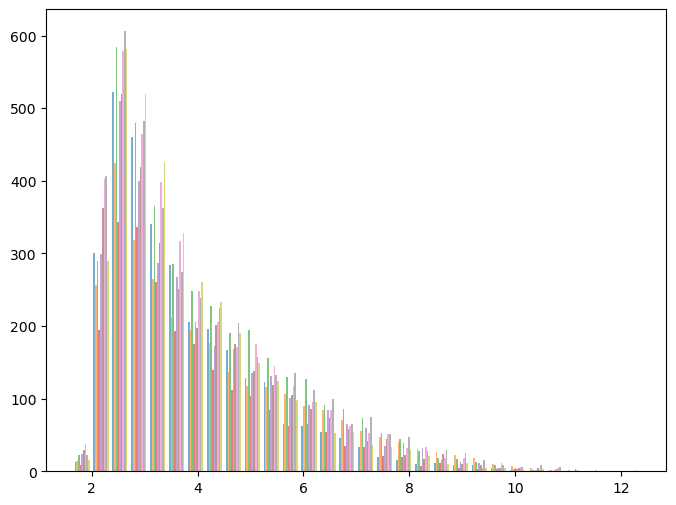

In [85]:
plt.figure(figsize=(8, 6))
plt.hist(inner_dist, bins=30, alpha=0.6, label='Dataset 1')
plt.show()


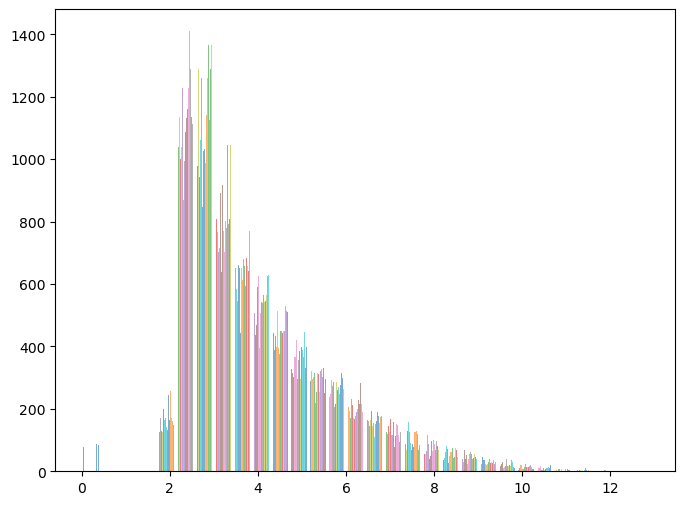

In [86]:
plt.figure(figsize=(8, 6))
plt.hist(inter_dist, bins=30, alpha=0.6, label='Dataset 1')
plt.show()